<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/hand%20sign%20digits%20detector%5Bcnn%2Btf%5D/hand_sign_digits_detector%5Bcnn%2Btf%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hand Sign Digits Detector**

We'll use Keras' flexible [Functional API](https://www.tensorflow.org/guide/keras/functional) to build a ConvNet that can differentiate between 6 sign language digits. 

The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs. Where the Sequential API requires the model to move in a linear fashion through its layers, the Functional API allows much more flexibility. Where Sequential is a straight line, a Functional model is a graph, where the nodes of the layers can connect in many more ways than one. 


In [ ]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

In [ ]:
# Helper Functions

# SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5
def load_signs_dataset():
    train_dataset = h5py.File("train_signs.h5", "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File("test_signs.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


# what we are simply doing is using np.eye() to create a diagonal matrix with each class index as 1 rest zero 
# and later using the indexes provided by a.reshape(-1) producing the output corresponding to the index in np.eye()
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y    

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 4


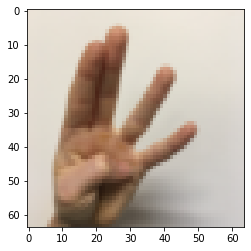

In [ ]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print (f"y = {np.squeeze(Y_train_orig[:, index])}")

In [ ]:
# Normalization
X_train = X_train_orig/255
X_test = X_test_orig/255

# Reshape
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print (f"number of training examples = {X_train.shape[0]}")
print (f"number of test examples = {X_test.shape[0]}")
print (f"X_train shape = {X_train.shape}")
print (f"Y_train shape = {Y_train.shape}")
print (f"X_test shape = {X_test.shape}")
print (f"Y_test shape = {Y_test.shape}")

number of training examples = 1080
number of test examples = 120
X_train shape = (1080, 64, 64, 3)
Y_train shape = (1080, 6)
X_test shape = (120, 64, 64, 3)
Y_test shape = (120, 6)


**Convolutional Model**

We will build the following model:

 `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. 


plug in the following parameters for all the steps:

 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 4 by 4 filters, stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 2 by 2 filters, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 6 neurons and a softmax activation. 

In [ ]:
# convolutional model

def convolutional_model(input_shape):

    # input_img -> input dataset of shape (input_shape)
    # model -> TF Keras model (object containing the information for the entire training process) 


    input_img = tf.keras.Input(shape = input_shape)

    # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters = 8 , kernel_size = 4 , padding = "SAME", strides = 1)(input_img)
    
    # RELU
    A1 = tfl.ReLU()(Z1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size = 8, strides = 8, padding="SAME")(A1)
    
    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters = 16 , kernel_size = 2 , padding="SAME", strides = 1)(P1)
    
    # RELU
    A2 =  tfl.ReLU()(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size = 4, strides = 4, padding="SAME")(A2)
    
    # FLATTEN
    F = tfl.Flatten()(P2)
    
    # Dense layer
    # 6 neurons in output layer. one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(units= 6 , activation="softmax")(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)


    return model

In [ ]:
conv_model = convolutional_model((64,64,3))
conv_model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         392       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 16)          0         
                                                             

In [ ]:
# train model

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 3s 120ms/step - loss: 1.8239 - accuracy: 0.1667 - val_loss: 1.7915 - val_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 3s 201ms/step - loss: 1.7884 - accuracy: 0.1907 - val_loss: 1.7861 - val_accuracy: 0.1667
Epoch 3/100
17/17 [==============================] - 4s 205ms/step - loss: 1.7838 - accuracy: 0.1759 - val_loss: 1.7823 - val_accuracy: 0.1667
Epoch 4/100
17/17 [==============================] - 4s 219ms/step - loss: 1.7799 - accuracy: 0.2083 - val_loss: 1.7792 - val_accuracy: 0.2333
Epoch 5/100
17/17 [==============================] - 3s 196ms/step - loss: 1.7768 - accuracy: 0.2306 - val_loss: 1.7761 - val_accuracy: 0.2583
Epoch 6/100
17/17 [==============================] - 4s 223ms/step - loss: 1.7741 - accuracy: 0.2324 - val_loss: 1.7733 - val_accuracy: 0.2417
Epoch 7/100
17/17 [==============================] - 2s 115ms/step - loss: 1.7702 - accuracy: 0.2426 - val_loss: 1.7701 - val_accuracy: 0.2417

The history object is an output of the `.fit()` operation and provides a record of all the loss and metric values in memory. It's stored as a dictionary that we can retrieve at `history.history`

In [ ]:
history.history

{'accuracy': [0.1666666716337204,
  0.19074073433876038,
  0.17592592537403107,
  0.2083333283662796,
  0.23055554926395416,
  0.23240740597248077,
  0.24259258806705475,
  0.2361111044883728,
  0.2509259283542633,
  0.26944443583488464,
  0.28796297311782837,
  0.31388887763023376,
  0.34351852536201477,
  0.3907407522201538,
  0.40925925970077515,
  0.42407408356666565,
  0.45370370149612427,
  0.45092591643333435,
  0.4592592716217041,
  0.46388888359069824,
  0.4731481373310089,
  0.47870370745658875,
  0.4990740716457367,
  0.5175926089286804,
  0.5259259343147278,
  0.5453703999519348,
  0.5685185194015503,
  0.5842592716217041,
  0.5981481671333313,
  0.6231481432914734,
  0.6324074268341064,
  0.6425926089286804,
  0.6537036895751953,
  0.6638888716697693,
  0.6712962985038757,
  0.6851851940155029,
  0.6972222328186035,
  0.7074074149131775,
  0.7129629850387573,
  0.7250000238418579,
  0.7351852059364319,
  0.7425925731658936,
  0.75,
  0.760185182094574,
  0.7648147940635681

Now visualize the loss over time using `history.history`

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

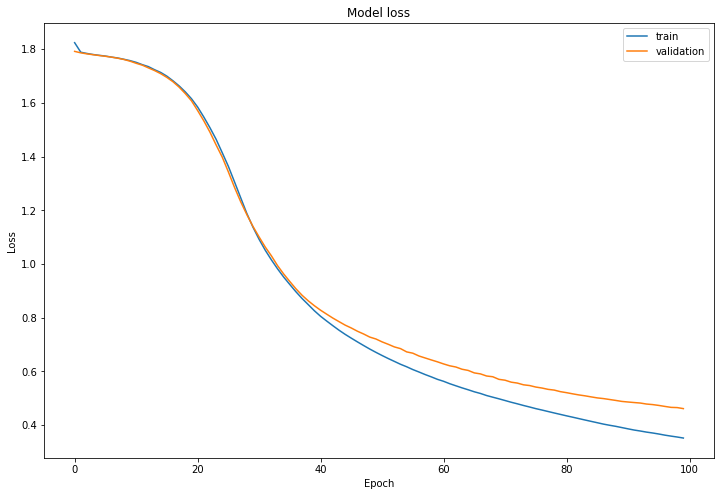

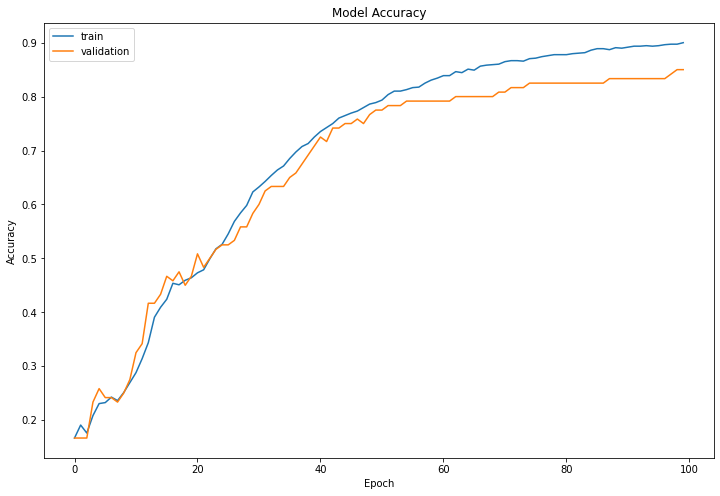

In [ ]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on 

df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss","val_loss"]]
df_loss.rename(columns = {"loss":"train","val_loss":"validation"},inplace = True)
df_acc = df_loss_acc[["accuracy","val_accuracy"]]
df_acc.rename(columns = {"accuracy":"train","val_accuracy":"validation"},inplace = True)
df_loss.plot(title = "Model loss",figsize=(12,8)).set(xlabel = "Epoch",ylabel = "Loss")
df_acc.plot(title = "Model Accuracy",figsize=(12,8)).set(xlabel = "Epoch",ylabel = "Accuracy")